In [1]:
import os
import json
import random

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Data

In [2]:
IMAGE_DIR = '../data/train/'
with open('../data/train/annotations.json') as json_data:
    data = json.load(json_data)

## Split Into Training/Val

In [3]:
train_ratio = 0.9

In [24]:
keys = list(data.keys())
random.shuffle(keys)
cutoff =int(train_ratio * len(keys))

train_data = {k: data[k] for k in keys[:cutoff] if len(data[k]) == 4}
val_data = {k: data[k] for k in keys[cutoff:] if len(data[k]) == 4}

print(f'Train Samples: {len(train_data)}, Val Samples: {len(val_data)}')

Train Samples: 274, Val Samples: 31


## Generators

### Load Data

In [25]:
from whale_lm_generator import WhaleLMGenerator

In [62]:
H, W = 124, 124
batch_size = 12

In [63]:
train_generator = WhaleLMGenerator(IMAGE_DIR, train_data, 4, dim=(H, W), batch_size=batch_size)
val_generator = WhaleLMGenerator(IMAGE_DIR, val_data, 4, dim=(H, W), batch_size=batch_size)

# Test Runner

In [8]:
def run_test(H, W, model):
    pass

# Training

In [9]:
from keras.models import Model, Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPool2D, Dense
from keras.layers import Activation, BatchNormalization, concatenate
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, Callback
from keras import applications
import keras.backend as K
import tensorflow as tf

from tensorboard_logger import TensorBoardLogger

# Losses and Metrics

In [10]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def jaccard(y_true, y_pred, threshold=0.5, axis=(1, 2, 3), smooth=1e-5): 
        pre = tf.cast(y_pred > threshold, dtype=tf.float32)
        truth = tf.cast(y_true > threshold, dtype=tf.float32)
        inse = tf.reduce_sum(tf.multiply(pre, truth), axis=axis)  # AND
        union = tf.reduce_sum(tf.cast(tf.add(pre, truth) >= 1, dtype=tf.float32), axis=axis)  # OR
        batch_iou = (inse + smooth) / (union + smooth)
        iou = tf.reduce_mean(batch_iou)
        return iou

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jacckard_loss(y_true, y_pred):
    return 1 - jaccard(y_true, y_pred)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
batch = train_generator[0]

images, gts = batch

sample = images[1]
gt = gts[1]

out = model.predict(sample[np.newaxis, :,])

plt.imshow(out[0,:,:,0])
# plt.imshow(gt[:,:,3])

NameError: name 'model' is not defined

In [ ]:
def create_sdn_model(H, W):
    x = Input((None, H, W))
    x = Conv2D(filters=5, kernel_size=5, activation='relu', strides=1)(x)
    

## Pre-Trained Model

In [51]:
def create_pretrained_model(base='VGG16'):
    
    if base == 'VGG16':
        base = applications.vgg16.VGG16(
                include_top=False, 
                weights=None, 
                pooling=None,
                input_shape=(H, W, 1),)
        for layer in base.layers[:5]:
            layer.trainable = False
    
    x = Flatten()(base.output)
    x = Dense(4096, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(256, activation='relu')(x)

    out = Dense(8, activation='linear')(x)
    
    model = Model(inputs=base.input, outputs=out)
    
    optimizer = Adam(lr=1e-4)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    return model

In [52]:
model = create_pretrained_model(base='VGG16')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [53]:
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in lrs:
    print(f'Learning Rate: {lr}')
    K.set_value(model.optimizer.lr, lr)
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        workers=6,
        epochs=1
    )

Learning Rate: 1e-06
Epoch 1/1
100/100 [==============================] - 12s 119ms/step - loss: 0.2915 - acc: 0.0000e+00
Learning Rate: 1e-05
Epoch 1/1
100/100 [==============================] - 12s 115ms/step - loss: 0.0661 - acc: 0.6575
Learning Rate: 0.0001
Epoch 1/1
100/100 [==============================] - 12s 116ms/step - loss: 0.0187 - acc: 0.9225
Learning Rate: 0.001
Epoch 1/1
100/100 [==============================] - 12s 117ms/step - loss: 0.0941 - acc: 0.8375
Learning Rate: 0.01
Epoch 1/1
100/100 [==============================] - 12s 121ms/step - loss: 0.0108 - acc: 0.9242


In [64]:
model = create_pretrained_model(base='VGG16')
tensorboard = TensorBoardLogger(log_name='VGG-48')

In [65]:
# model.load_weights('checkpoints/VGG-224')

In [66]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
    validation_data=val_generator,
    validation_steps=50,
    workers=6,
    epochs=2,
)

In [67]:
K.set_value(model.optimizer.lr, 1e-3)

In [71]:
model.fit_generator(**fit_args)

Epoch 1/2
200/200 [==============================] - 38s 188ms/step - loss: 0.0103 - acc: 0.9233 - val_loss: 0.0104 - val_acc: 0.9367
Epoch 2/2
200/200 [==============================] - 37s 184ms/step - loss: 0.0101 - acc: 0.9246 - val_loss: 0.0102 - val_acc: 0.9467


In [69]:
def show_landmarks(image, landmarks):
    """Show image with landmarks."""
    h, w = image.shape[:2]
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0] * w, landmarks[:, 1] * h, s=70, marker='.', c='#00FF00')

2
0 (124, 124, 1), (8,)
[ 0.07447218  0.18293123  0.47258747  0.47716439  0.88137424  0.21769138
  0.47293437  0.76018471]
1 (124, 124, 1), (8,)
[ 0.07447127  0.18292753  0.47257912  0.47715569  0.88135791  0.21768707
  0.4729251   0.76017076]
2 (124, 124, 1), (8,)
[ 0.07447334  0.18293519  0.47259653  0.47717395  0.88139212  0.21769583
  0.47294429  0.76019961]
3 (124, 124, 1), (8,)
[ 0.07447065  0.18292521  0.472574    0.47715047  0.88134825  0.21768448
  0.47291946  0.76016229]
4 (124, 124, 1), (8,)
[ 0.07447452  0.18293932  0.47260588  0.47718382  0.88141054  0.21770084
  0.47295484  0.76021534]
5 (124, 124, 1), (8,)
[ 0.07447254  0.18293267  0.4725908   0.47716773  0.88138056  0.21769291
  0.47293791  0.76018983]
6 (124, 124, 1), (8,)
[ 0.07447571  0.18294397  0.47261649  0.47719559  0.88143247  0.21770647
  0.47296691  0.76023346]
7 (124, 124, 1), (8,)
[ 0.07447047  0.1829244   0.47257215  0.47714821  0.88134414  0.21768354
  0.47291732  0.76015919]
8 (124, 124, 1), (8,)
[ 0.0744

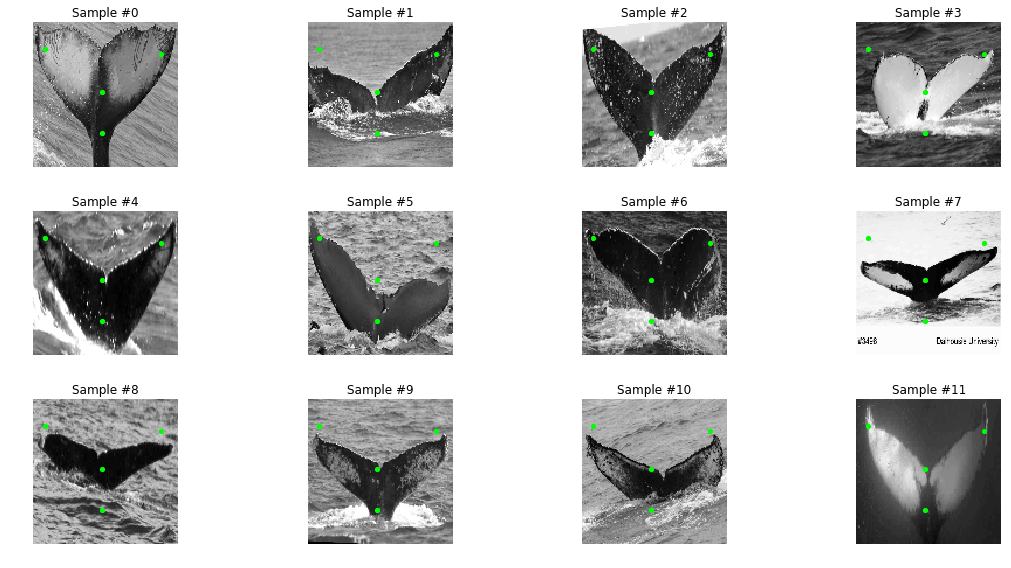

In [70]:
fig = plt.figure(figsize=(16, 8))

images, _ = val_generator[0]

landmarks = model.predict(images)

print(len(batch))

for i in range(len(images)):
    im, lm = images[i], landmarks[i]
    
    print(f"{i} {im.shape}, {lm.shape}")
    
    ax = plt.subplot(3, 4, i + 1)
    plt.tight_layout()
    ax.set_title(f'Sample #{i}')
    ax.axis('off')
    show_landmarks(im[:,:,0], lm.reshape((4, 2)))
    print(lm)
    
    if i == 12:
        plt.show()
        break

In [97]:
model.save_weights('../checkpoints/VGG-48')

In [109]:
from skimage import io, transform

predictions = {}

file_names = [os.path.join(IMAGE_DIR, fn) for fn in os.listdir(IMAGE_DIR)
              if any(fn.endswith(ext) for ext in ['jpg', 'png'])]

for fn in file_names[:2]:
    im = io.imread(fn, as_grey=True)
    im = transform.resize(im, (H, W))
    im = im[np.newaxis, :, :, np.newaxis]
    y = model.predict(im)
    y = y.reshape(4, 2)
    y = [{'x': p[0], 'y': p[1]} for p in y]
    
    predictions[fn] = y

print(predictions)
    

{'../data/train/da1df29f.jpg': [{'x': nan, 'y': 0.4912205}, {'x': 0.49869746, 'y': 0.49829412}, {'x': 0.50887376, 'y': 0.49121517}, {'x': nan, 'y': nan}], '../data/train/0f51444d.jpg': [{'x': nan, 'y': 0.4912205}, {'x': 0.49869746, 'y': 0.49829412}, {'x': 0.50887376, 'y': 0.49121517}, {'x': nan, 'y': nan}]}


In [ ]:
run_test(H, W, model)

## UNET

In [75]:
def get_unet(H, W, C):
    def conv_block(in_layer, filters, pooling=True):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(in_layer)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        mp = MaxPool2D(pool_size=(2, 2))(x) if pooling else None
        return x, mp
    
    def up_block(in_layer, conv_layer, filters):
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(in_layer)
        x = concatenate([x, conv_layer], axis=3)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        return x
    
    inputs = Input((H, W, C))
    
    c1, mp = conv_block(inputs, 32)
    c2, mp = conv_block(mp, 64)
    c3, mp = conv_block(mp, 128)
    c4, mp = conv_block(mp, 256)
    c5, _ = conv_block(mp, 512, pooling=False)
    
    x = up_block(c5, c4, 256)
    x = up_block(x, c3, 128)
    x = up_block(x, c2, 64)
    x = up_block(x, c1, 32)
    
    out = Conv2D(4, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[dice_coef, jaccard, 'accuracy'])

    return model

In [76]:
model = get_unet(H, W, 1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_107 (Conv2D)             (None, 32, 32, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 32, 32, 32)   9248        conv2d_107[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_17 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_108[0][0]                 
__________________________________________________________________________________________________
conv2d_109

In [ ]:
lrs = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
for lr in lrs:
    print(f'Learning Rate: {lr}')
    K.set_value(model.optimizer.lr, lr)
    model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=1
    )

In [101]:
model = get_unet(H, W, 1)
tensorboard = TensorBoardLogger(log_name='UNET-64')

In [ ]:
model.load_weights('checkpoints/unet-64.h5')

In [105]:
K.set_value(model.optimizer.lr, 1e-5)

In [103]:
fit_args = dict(
    generator=train_generator,
    steps_per_epoch=200,
    callbacks=[tensorboard],
#     validation_data=val_generator,
#     validation_steps=100,
    workers=6,
    epochs=10,
)

In [106]:
model.fit_generator(**fit_args)

Epoch 1/10
200/200 [==============================] - 32s 161ms/step - loss: 0.0155 - dice_coef: 0.0208 - jaccard: 0.0129 - acc: 0.999017s - loss: 0.0155 - dic - ETA: 11s - lo
Epoch 2/10
  7/200 [>.............................] - ETA: 18s - loss: 0.0155 - dice_coef: 0.0208 - jaccard: 0.0119 - acc: 0.9990

KeyboardInterrupt: 

In [ ]:
model.save_weights('checkpoints/unet-64.h5')

In [ ]:
run_test(H, W, model)